In [1]:
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import scipy
import nltk
import re
import string
import gensim
nltk.download('punkt')
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Path to output csv files
out_path = r"C:\Users\Owner\Documents\School\Masters of Science in Analytics\Semesters\Spring Semester\Social Network Analysis\Output Data"


# Collect Links to Political News Articles Using Azure Bing Search API

In [2]:
# Enter the API Access Credentials
subscription_key = ### Enter Your API Subscription Key Here ###
search_url = "https://api.cognitive.microsoft.com/bing/v7.0/news/search"
headers = {"Ocp-Apim-Subscription-Key" : subscription_key}

In [4]:
# Function to flatten a list of lists
def flatten( in_list ):
    return [item for sublist in in_list for item in sublist]

In [3]:
titles = []

links = []

sources = []

publish_dates = []

# Can only pull 100 artilces at a time, so this will pull them in 100 artilce increments
starts = [0, 100, 200]

# Search terms for the query
search_terms = ["USA Election Politics", "2020 Presidential Election", "Joe Biden", "Bernie Sanders", "elizabeth warren",
                "pete buttigieg", "Donald Trump", "Super Tuesday", "republican national convention 2020",
                "democratic national convention 2020", "presidential debates 2020", "micheal bloomberg", "trump rally",
                "democratic caucus 2020", "Politics united states 2020 presidential election opinion"]

for term in search_terms:
    
    for start in starts: 

        params  = {"q": term, "textDecorations": True, "textFormat": "HTML", 
                   "count":100, "safeSearch":"Off", "cc":"en-US", 
                   'since':'2020-01-01', "offset": start}

        response = requests.get(search_url, headers=headers, params=params)
        response.raise_for_status()
        search_results = response.json()

        titles.append([article['name'] for article in search_results["value"]])

        links.append([article['url'] for article in search_results["value"]])

        sources.append([article['provider'][0]['name'] for article in search_results["value"]])

        publish_dates.append([article['datePublished'] for article in search_results["value"]])


titles = flatten( titles )

links = flatten( links )

sources = flatten( sources )

publish_dates = flatten( publish_dates )

NameError: name 'flatten' is not defined

In [25]:
# Push the article links to a CSV file
df = pd.DataFrame( [publish_dates, sources, titles, links], index = ['Publish_Date', 'News_Source', 'Article_Title', 'Link'] ).T

# Remove Duplucate links
df = df.drop_duplicates( subset = 'Link')

df = df.reset_index(drop=True)

df.to_csv( out_path + '\\azure_article_links.csv', index = False)

# Scrape Article Text Using the Collected Links

In [ ]:
unique_links = df['Link'].to_list()

article_text = [None]*len(unique_links)

failed = []

for i in range( 0, len(unique_links) ):
    
    # Print progress on every 100 articles
    if (i % 100) == 0: 
        
        print( i,'of',len(unique_links),'complete' )
    
    # Sometimes text scraping fails, so we implement try and except
    try:
        r1 = requests.get(unique_links[i])
        coverpage = r1.content
        
        soup1 = BeautifulSoup(coverpage, 'html5lib')
        
        # Find all HTML paragraph elements
        body = soup1.find_all('p')
        text = [None]*len(body)
        
        body_count = 0
        
        # Append all paragraphs to list
        for p in body:
            paragraph = p.get_text()
            text[body_count] = paragraph
            body_count += 1

        one_block = ''
        
        # Break paragraphs into tokenized text elements
        for line in text:
            one_block += " " + line
        
        # Append the article
        article_text[i] = one_block
    
    # If scraping fails, print a warning and store index of failure
    except:
        failed.append(i)
        print("Failed on iteration", i)

0 of 2022 complete
Failed on iteration 5
Failed on iteration 32


In [ ]:
# Output data to csv
df['Article_Text'] = article_text
df.to_csv(out_path + '\\Azure_article_links_and_news_text.csv', index = False)

# Preprocess Topics Using Tokenization, Porter Stemming, Stop Word Removal, and Punctuation Removal

In [99]:
# Even though a run didn't fail some document entries are blank. Here we drop those entries. 

docs = df[['News_Source', 'Article_Text']].dropna(axis = 0)

docs = docs[docs['Article_Text'] != ' ']

In [92]:
# Function to tokenize sentences
def tokenize_sentences( documents ):
    
    documents = list(documents)
    
    tokens = [None]*len(documents)
    
    for x in range(0,len(documents)):

            document = str(documents[x])
            
            # Tokenize the sentences
            tokens[x] = sent_tokenize(document)
    
    return tokens


# Function to tokenize words
def tokenize_words( documents ):
    
    documents = list(documents)
    
    tokens = [None]*len(documents)
    
    for x in range(0,len(documents)):
        
        document = str(documents[x])

        # Split into words
        tokens[x] = word_tokenize(document)

    return tokens


# Fucntion to convert words to a lowercase format
def to_lowercase( documents ):
    
    documents = list(documents)
    
    tokens = [None]*len(documents)
    
    for x in range(0,len(documents)):
        
        tokens[x] = [w.lower() for w in documents[x]]
    
    return tokens


# Fucntion to remove any punctiation and numbers
def remove_puct( documents ): 
    
    documents = list(documents)
    
    tokens = [None]*len(documents)
    
    for x in range(0,len(documents)):
        
        tokens[x] = [word for word in documents[x] if word.isalpha()]
    
    return tokens


# Fucntion to remove common stop words
def remove_stops( documents ):
    
    stop_words = set(stopwords.words('english'))
    
    documents = list(documents)
    
    tokens = [None]*len(documents)
    
    for x in range(0,len(documents)):
        
        tokens[x] = [w for w in documents[x] if not w in stop_words]
    
    return tokens


# Function to perform porter stemming
def porter_stem( documents ): 
    
    porter = PorterStemmer()
    
    documents = list(documents)
    
    tokens = [None]*len(documents)
    
    for x in range(0,len(documents)):
        
        tokens[x] = [porter.stem(word) for word in documents[x]]
    
    return tokens



# Fucntion that combines the above oberations in to a comprehensive preprocessing pipeline
def document_preprocessor(raw_docs, remove_punctuation = True, porter_stemming = True, lowercase_words = True, 
                          remove_stopwords = True):
    
    raw_docs = raw_docs.copy(deep=True)
    
    if type(raw_docs) != list: 
        
        raw_docs = list(raw_docs)
        
    processed_docs = tokenize_words( documents = raw_docs )
    
    if lowercase_words: 
        processed_docs = to_lowercase( processed_docs )
        
    if remove_punctuation: 
        processed_docs = remove_puct(processed_docs)
        
    if remove_stopwords: 
        processed_docs = remove_stops( documents = processed_docs )
        
    if porter_stemming:
        processed_docs = porter_stem( documents = processed_docs )
        
    return processed_docs


In [101]:
output = document_preprocessor(raw_docs = docs['Article_Text'])
pd.DataFrame(output).to_csv(out_path + '\\tokenized_documents', index = False)

# Preprocess Topics and Create a Bag of Words Model

In [110]:
# Generate words and bigrams as phrases (i.e. 'computer' and 'science' tokens become 'computer_science')
bigram = gensim.models.Phrases(output, min_count = 20, threshold = 20,  delimiter = b'_')

# Generate the bigram topic model
bigram_model = gensim.models.phrases.Phraser(bigram)

# Store the bigram topic phrases in a list
corpus_bigrams = [bigram_model[doc] for doc in output]

# Create a dictionary for the phrases generated in our topic generator
dictionary = gensim.corpora.Dictionary(corpus_bigrams)

dictionary.filter_extremes( no_below = 20, no_above = 0.6 )

# Create a bag of words using our corpus disctionary
bow_corpus = [dictionary.doc2bow(text) for text in corpus_bigrams]

# Create a dictionary for the phrases generated in our topic generator
print('There are', len(dictionary), 'terms in our dictionary across', len(bow_corpus), 'news articles')

There are 3354 terms in our dictionary across 1555 new articles


# Explore Latent Dirichlet Allocation (LDA) Models

In [124]:
# Fucntion to find the best number of topics using coherence score. 
# Note: This fucntion references global variables from the topic preprocessing step
def test_LDAs(lower_topics = 4, upper_topics = 16, step_size = 2):
    
    num_models = (upper_topics - lower_topics) / step_size
    
    # Iterate through topic numbers to find an optimal number of topics
    coherence_scores = []
    
    models = {}
    
    count = 1

    for i in range(lower_topics, upper_topics, step_size): 
        
        print('Testing model', count, 'of', num_models)
        count += 1

        lda_model = gensim.models.LdaModel(corpus = bow_corpus, id2word = dictionary, chunksize = len(output), 
                                           alpha = 'auto', eta = 'auto', random_state = 123, iterations = 500, 
                                          num_topics = i, passes = 20, eval_every = None)

        cv_coh = gensim.models.CoherenceModel(model=lda_model, corpus = bow_corpus, 
                                             texts = corpus_bigrams, dictionary = dictionary, coherence = 'c_v')

        coherence_scores.append( cv_coh.get_coherence() )
        
        models[str(i)] = lda_model

    # Plot the relationship between number of topics and the coherence score
    x = [i for i in range(lower_topics, upper_topics, step_size)]

    plt.plot(x, coherence_scores)

    plt.xlabel('Number of Topics')

    plt.ylabel('Coherence Score')

    plt.show()
    
    return models

Testing model 1 of 2.0
Testing model 2 of 2.0


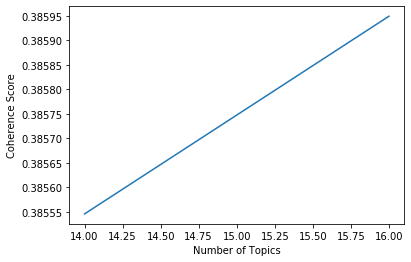

In [128]:
lda_model_objs = test_LDAs(lower_topics = 14, upper_topics = 18, step_size = 2)

In [129]:
lda_model = lda_model_objs['16']
lda_topic_model = lda_model[bow_corpus]
lda_topic_model_scores = [topic for topic in lda_topic_model]

In [149]:
# Build a document lookup tables
doc_index = ['Doc_'+str(i) for i in range(1, len(output)+1)]
docs.index = doc_index
docs = docs.reset_index()
docs.to_csv(out_path + '\\article_information_table.csv')

In [142]:
# Create a fucntion that builds a document-topic matrix containing topic scores by document
def doc_topic(topic_model, num_topics = 16): 
    
    topic_model = topic_model[bow_corpus]

    topic_model_scores = [topic for topic in topic_model]
    
    doc_topic_matrix = []

    for doc in topic_model_scores: 

        id_list = [0]*16

        for index, sim_score in doc: 

            id_list[index] = sim_score

        doc_topic_matrix.append(id_list)

    doc_topic_matrix = pd.DataFrame(doc_topic_matrix, columns = ['Topic_'+str(i) for i in range(1,num_topics+1)], 
                                    index = ['Doc_'+str(i) for i in range(1, len(output)+1)])
    
    return doc_topic_matrix


In [150]:
# Build a document-topic matrix containing LDA topic scores by document
   
lda_doc_topic_matrix = doc_topic(topic_model = lda_model_objs['16'], num_topics = 16)

lda_doc_topic_matrix.to_csv( out_path + '\\lda_doc_topic_matrix.csv')

lda_doc_topic_matrix.head()

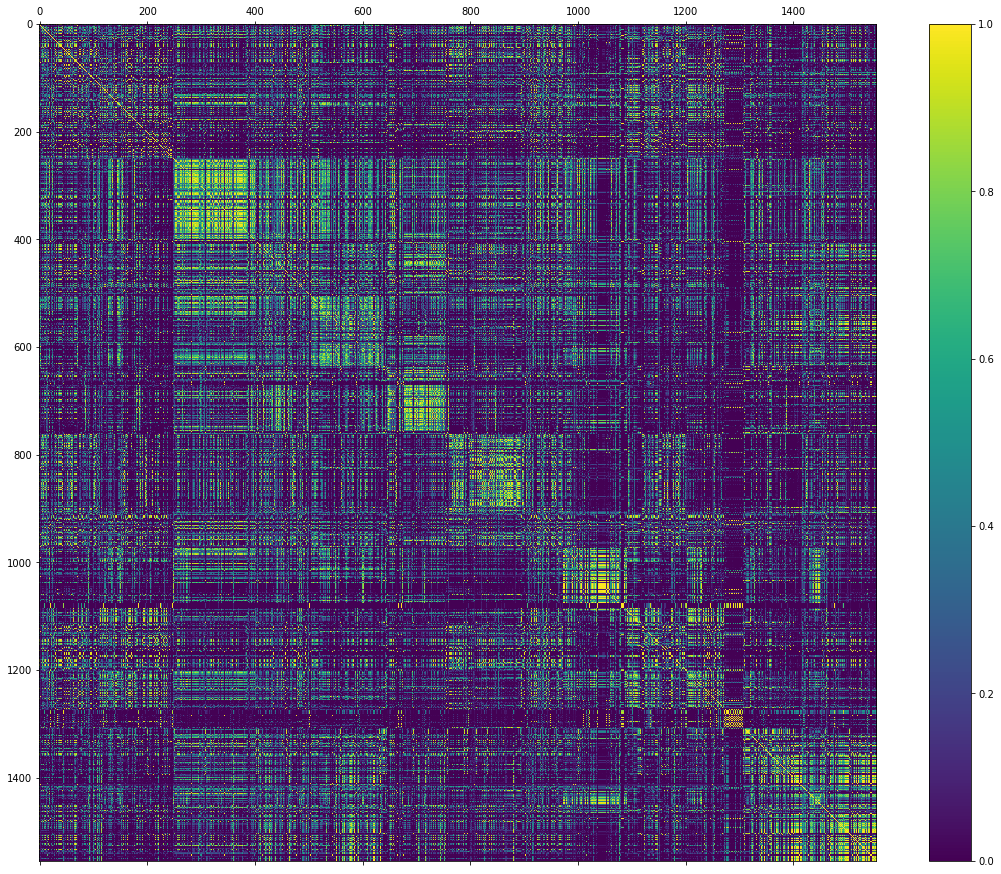

In [157]:
# Construct a topic similarity matrix
lda_document_sim_matrix = cosine_similarity(lda_doc_topic_matrix, lda_doc_topic_matrix)

f = plt.figure(figsize=(19, 15))

plt.matshow(lda_document_sim_matrix, fignum=f.number)

cb = plt.colorbar()

## Resulting LDA Network Constructed in Gephi

# 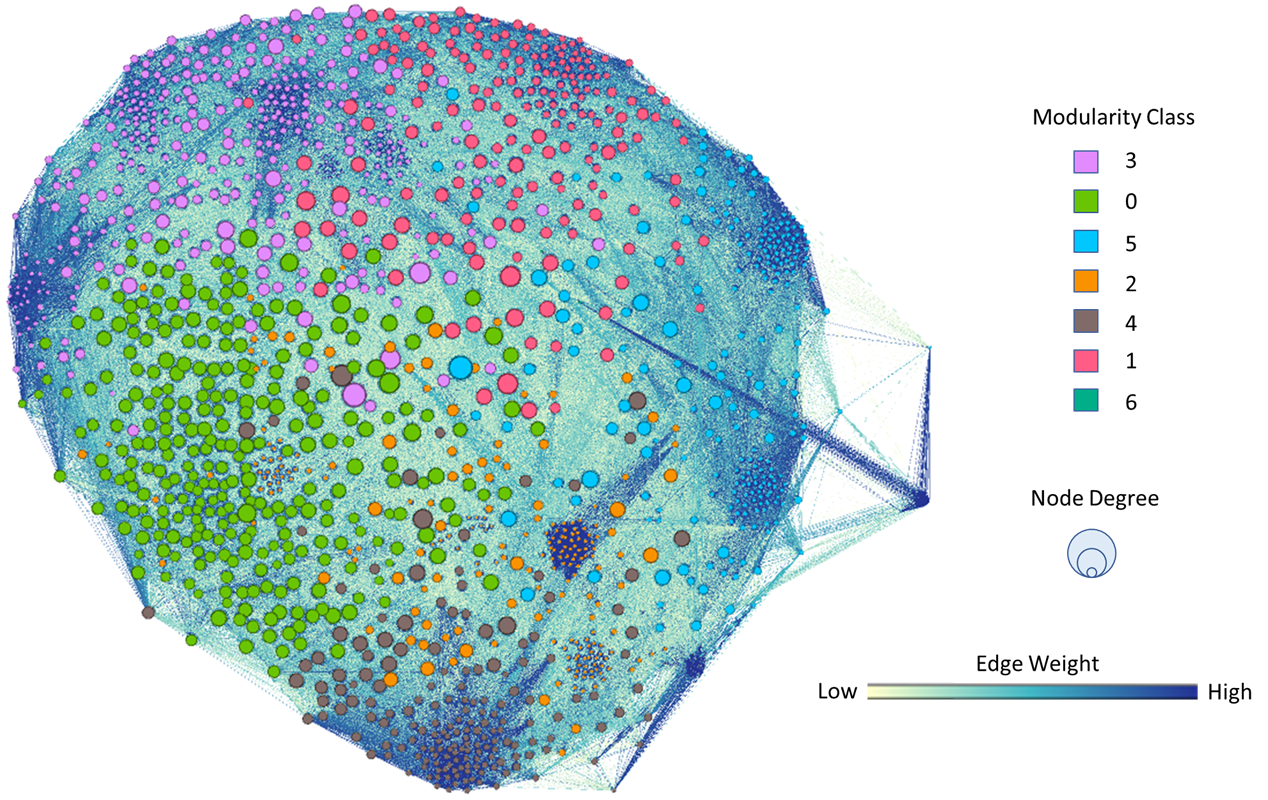

# Build a Latent Semantic Indexing Model

In [151]:
# We will build an LSI model using the same number of topics as we used in the LDA model
lsi_model = gensim.models.lsimodel.LsiModel(corpus = bow_corpus, id2word = dictionary, chunksize = len(output), 
                                            num_topics = 16)

# Build a document-topic matrix containing LDA topic scores by document
lsi_doc_topic_matrix = doc_topic(topic_model = lsi_model, num_topics = 16)

lsi_doc_topic_matrix.to_csv( out_path + '\\lsi_doc_topic_matrix.csv')

lsi_doc_topic_matrix.head()

Topic_1   Topic_2   Topic_3    Topic_4   Topic_5   Topic_6   Topic_7  \
Doc_1  23.592615 -6.561626  2.167310 -13.300938 -1.305479  3.646749  4.281277   
Doc_2   9.681945 -1.120217  4.493041   4.796239  0.256125  4.515502 -0.325669   
Doc_3   0.012213 -0.005162 -0.003029  -0.000718  0.013792  0.010041  0.001702   
Doc_4   9.338749 -1.408012  0.572292  -4.965585 -0.753810  2.012208  0.520850   
Doc_5   4.501791 -2.062494  1.466568  -1.272459 -1.089331  0.333782 -0.121399   

        Topic_8   Topic_9  Topic_10  Topic_11  Topic_12  Topic_13  Topic_14  \
Doc_1 -8.040286 -5.046299 -1.333677  4.142156  2.951331  4.931693  3.122382   
Doc_2 -2.564887 -0.776913  1.331512 -1.680456  0.017078  1.844444  0.666262   
Doc_3 -0.002766  0.008630  0.002975  0.004257 -0.004914  0.007681  0.005457   
Doc_4 -3.775498 -0.218639 -0.672687  0.396442 -0.457704  0.139799 -0.081211   
Doc_5 -0.499247  0.419544 -0.788202 -0.262061 -0.196947  1.363132  1.483698   

       Topic_15  Topic_16  
Doc_1  0.786287 -3.439801  
Doc_2  4.196109 -0.455021  
Doc_3  0.002680 -0.000903  
Doc_4  1.015358  0.913711  
Doc_5 -0.056680 -0.128473

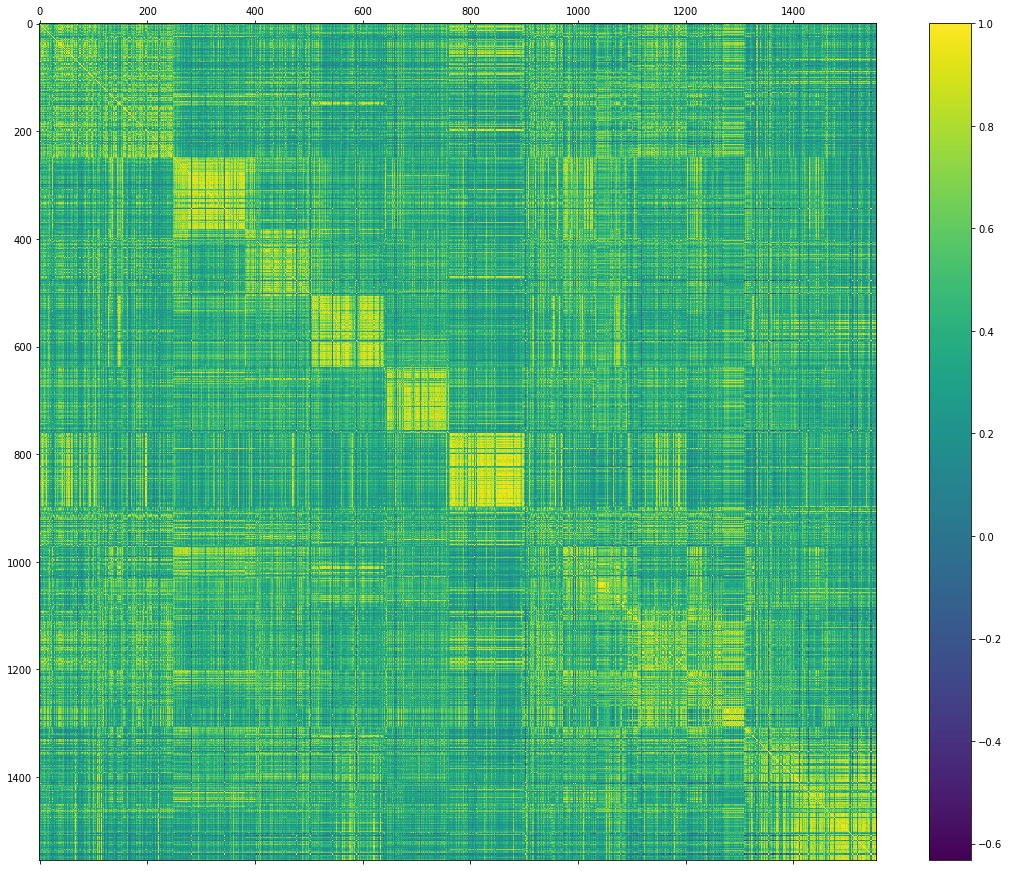

In [158]:
# Construct a topic similarity matrix
lsi_document_sim_matrix = cosine_similarity(lsi_doc_topic_matrix, lsi_doc_topic_matrix)

f = plt.figure(figsize=(19, 15))

plt.matshow(lsi_document_sim_matrix, fignum=f.number)

cb = plt.colorbar()

## Resulting LSI Network Constructed in Gephi

# 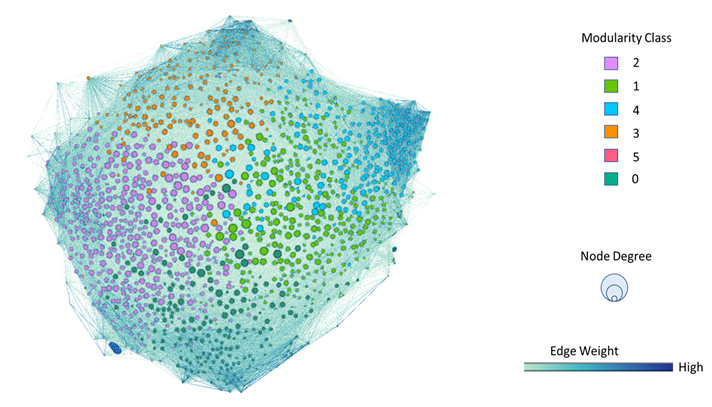